# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [78]:
# Add your imports here
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [79]:
# Additional settings
pandas.set_option('display.max_columns', None)
sns.set_theme(style="white")

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [33]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name__other,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,False,Pidove,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,False,Tepig,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,NaN,Garbodor,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,False,Tauros,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,False,Mr. Mime,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False


In [34]:
categorical_df = data[['Name','Type 1','Type 2','Generation','Legendary','Name__other','Type 1__other','Type 2__other','Generation__other','Legendary__other','Wins']]
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   Generation         36007 non-null  float64
 4   Legendary          36019 non-null  object 
 5   Name__other        36037 non-null  object 
 6   Type 1__other      35990 non-null  object 
 7   Type 2__other      19406 non-null  object 
 8   Generation__other  36014 non-null  float64
 9   Legendary__other   36018 non-null  object 
 10  Wins               40000 non-null  bool   
dtypes: bool(1), float64(2), object(8)
memory usage: 3.4+ MB


In [35]:
continuous_df = data[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','HP__other','Attack__other','Defense__other','Sp. Atk__other','Sp. Def__other','Speed__other']]
continuous_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              35994 non-null  float64
 1   Attack          36103 non-null  float64
 2   Defense         35966 non-null  float64
 3   Sp. Atk         36080 non-null  float64
 4   Sp. Def         36018 non-null  float64
 5   Speed           36028 non-null  float64
 6   HP__other       35895 non-null  float64
 7   Attack__other   36005 non-null  float64
 8   Defense__other  35984 non-null  float64
 9   Sp. Atk__other  35904 non-null  float64
 10  Sp. Def__other  35995 non-null  float64
 11  Speed__other    35956 non-null  float64
dtypes: float64(12)
memory usage: 4.0 MB


2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot:>

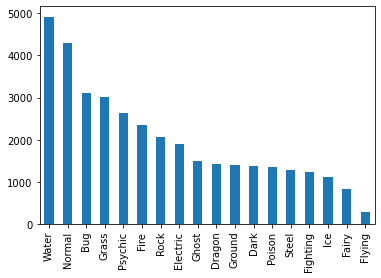

In [46]:
data['Type 1'].value_counts().plot(kind='bar')

3. Determine which of the features have missing values. How many missing values there are for each one?

In [56]:
# Columns with missing values
list(data.columns[data.isnull().any()])

['Name',
 'Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation',
 'Legendary',
 'Name__other',
 'Type 1__other',
 'Type 2__other',
 'HP__other',
 'Attack__other',
 'Defense__other',
 'Sp. Atk__other',
 'Sp. Def__other',
 'Speed__other',
 'Generation__other',
 'Legendary__other']

In [57]:
# Count Missing Values for each column
data.isnull().sum()

Name                  3994
Type 1                3974
Type 2               20535
HP                    4006
Attack                3897
Defense               4034
Sp. Atk               3920
Sp. Def               3982
Speed                 3972
Generation            3993
Legendary             3981
Name__other           3963
Type 1__other         4010
Type 2__other        20594
HP__other             4105
Attack__other         3995
Defense__other        4016
Sp. Atk__other        4096
Sp. Def__other        4005
Speed__other          4044
Generation__other     3986
Legendary__other      3982
Wins                     0
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

<AxesSubplot:>

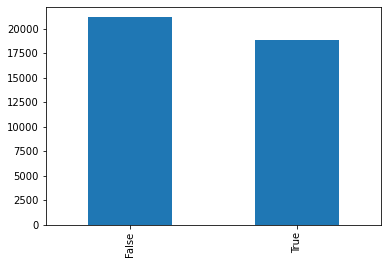

In [53]:
data['Wins'].value_counts().plot(kind='bar')

As we can see in the bar plot, the target column is balanced it has more or less the same quantity wins/loss.

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

<AxesSubplot:>

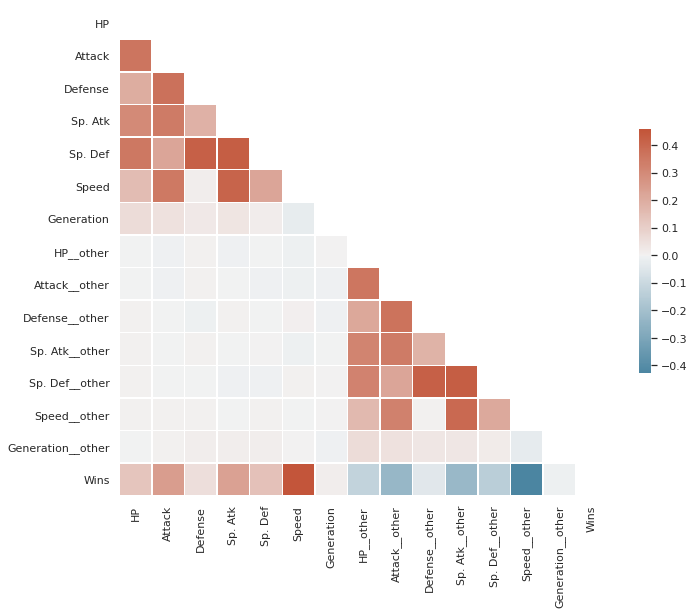

In [77]:
# Filter Data

# Clean Data

# Normalize Categorical Data and 


data.corr(method ='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Reduce Dataframe

# Clean Missing Values

In [60]:
reduced_data = data[['']]
clean_data = reduced_data.dropna()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 13653 to 35920
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1061 non-null   object 
 1   Type 1             1061 non-null   object 
 2   Type 2             1061 non-null   object 
 3   HP                 1061 non-null   float64
 4   Attack             1061 non-null   float64
 5   Defense            1061 non-null   float64
 6   Sp. Atk            1061 non-null   float64
 7   Sp. Def            1061 non-null   float64
 8   Speed              1061 non-null   float64
 9   Generation         1061 non-null   float64
 10  Legendary          1061 non-null   object 
 11  Name__other        1061 non-null   object 
 12  Type 1__other      1061 non-null   object 
 13  Type 2__other      1061 non-null   object 
 14  HP__other          1061 non-null   float64
 15  Attack__other      1061 non-null   float64
 16  Defense__other     

## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [6]:
# Your code here...

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [ ]:
# Your code here...

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [7]:
# Your code here...